This notebook relies on this PyImageSearch blog post [OpenCV Text Detection (EAST text detector)](https://www.pyimagesearch.com/2018/08/20/opencv-text-detection-east-text-detector/) to convert a pre-trained EAST model to TFLite.

From the blog post:
> The EAST pipeline is capable of predicting words and lines of text at arbitrary orientations on 720p images, and furthermore, can run at 13 FPS, according to the authors.

EAST was proposed in [An Efficient and Accurate Scene Text Detector](https://arxiv.org/abs/1704.03155). 

## Setup

In [33]:
import tensorflow as tf
tf.__version__

'2.9.1'

In [55]:
from imutils.object_detection import non_max_suppression
from imutils import paths
import numpy as np
import time
import cv2
import os
import matplotlib.pyplot as plt

%matplotlib inline

Fontconfig warning: ignoring UTF-8: not a valid region tag


## Executing the code from the blog post

We will be first executing the original codebase to just have a test of the results. 

In [41]:
!git clone https://github.com/dilhelh/opencv-text-detection.git

Cloning into 'opencv-text-detection'...
remote: Enumerating objects: 11, done.
remote: Total 11 (delta 0), reused 0 (delta 0), pack-reused 11
Receiving objects: 100% (11/11), 86.25 MiB | 10.10 MiB/s, done.
Resolving deltas: 100% (1/1), done.


In [42]:
!python3 opencv-text-detection/text_detection.py --image opencv-text-detection/images/lebron_james.jpg --east opencv-text-detection/frozen_east_text_detection.pb

[INFO] loading EAST text detector...
[INFO] text detection took 0.143207 seconds


**Note**: Be sure to comment out the last two lines of `text_detection.py` script and add `cv2.imwrite("image.png", orig)`. After you are done executing the script see the result by opening "image.png".

## TFLite model conversion

If we export the float16 model with a fixed known input shape we can can likely accelerate its inference with TFLite GPU delegate. We can specify the `input_shapes` argument in the `tf.compat.v1.lite.TFLiteConverter.from_frozen_graph()` function to do this. We are going to follow this same principle for other quantization (i.e. int8 and dynamic-range) methods as well. 

In order to use integer quantization we need a representative dataset. We will be using the [COCO-Text dataset](https://vision.cornell.edu/se3/coco-text-2/) for this purpose. As the dataset is pretty heavy in size, I have prepapred a small subset of it by sampling 100 training images randomly. 

In [43]:
!wget -q https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.11.0/coco_text_100.tar.gz
!tar xf coco_text_100.tar.gz

In [44]:
IMAGE_LIST = list(paths.list_images('/coco_text_100'))
IMG_SIZE = 320

In [45]:
def representative_dataset_gen():
    for image_path in IMAGE_LIST:
        image = cv2.imread(image_path)
        image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
        image = image.astype("float32")
        mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
        image -= mean
        image = np.expand_dims(image, axis=0)
        yield [image]

In [46]:
quantization = "int8" #@param ["dr", "int8", "float16"]
converter = tf.compat.v1.lite.TFLiteConverter.from_frozen_graph(
    graph_def_file='opencv-text-detection/frozen_east_text_detection.pb', 
    input_arrays=['input_images'],
    output_arrays=['feature_fusion/Conv_7/Sigmoid', 'feature_fusion/concat_3'],
    input_shapes={'input_images': [1, 320, 320, 3]}
)

converter.optimizations = [tf.lite.Optimize.DEFAULT]

if quantization=="float16":
    converter.target_spec.supported_types = [tf.float16]
elif quantization=="int8":
    converter.representative_dataset = representative_dataset_gen
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.uint8
    converter.inference_output_type = tf.uint8

tflite_model = converter.convert()
open('east_model_{}.tflite'.format(quantization), 'wb').write(tflite_model)

Estimated count of arithmetic ops: 15.108 G  ops, equivalently 7.554 G  MACs
Estimated count of arithmetic ops: 15.108 G  ops, equivalently 7.554 G  MACs


2022-05-26 15:33:00.599830: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-05-26 15:33:00.599862: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-05-26 15:33:01.860384: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1972] Estimated count of arithmetic ops: 15.108 G  ops, equivalently 7.554 G  MACs

fully_quantize: 0, inference_type: 6, input_inference_type: 3, output_inference_type: 3
2022-05-26 15:33:05.921563: I tensorflow/compiler/mlir/lite/flatbuffer_export.cc:1972] Estimated count of arithmetic ops: 15.108 G  ops, equivalently 7.554 G  MACs



96210808

From the blog post:

```
# define the two output layer names for the EAST detector model that
# we are interested -- the first is the output probabilities and the
# second can be used to derive the bounding box coordinates of text
layerNames = [
	"feature_fusion/Conv_7/Sigmoid",
	"feature_fusion/concat_3"]
```

In [47]:
!ls -lh *.tflite
!ls -lh opencv-text-detection/frozen_east_text_detection.pb

-rw-r--r--  1 grindarius  staff    92M May 26 15:33 east_model_int8.tflite
-rw-r--r--  1 grindarius  staff    92M May 26 15:31 opencv-text-detection/frozen_east_text_detection.pb


We see a substantial reduction in the sizes of the TensorFLow Lite models compared to the original model size. 

## Inference

### Prepare an input image

In [48]:
def preprocess_image(image_path):
    # load the input image and grab the image dimensions
    image = cv2.imread(image_path)
    orig = image.copy()
    (H, W) = image.shape[:2]
    
    # set the new width and height and then determine the ratio in change
    # for both the width and height
    (newW, newH) = (320, 320)
    rW = W / float(newW)
    rH = H / float(newH)

    # resize the image and grab the new image dimensions
    image = cv2.resize(image, (newW, newH))
    (H, W) = image.shape[:2]

    # convert the image to a floating point data type and perform mean
    # subtraction
    image = image.astype("float32")
    mean = np.array([123.68, 116.779, 103.939][::-1], dtype="float32")
    image -= mean
    image = np.expand_dims(image, 0)

    return image, orig, rW, rH

In [49]:
image, orig, rW, rH = preprocess_image("opencv-text-detection/images/lebron_james.jpg")

### Perform inference

In [50]:
def perform_inference(tflite_path, preprocessed_image):
    interpreter = tf.lite.Interpreter(model_path=tflite_path)
    input_details = interpreter.get_input_details()
    
    if input_details[0]["dtype"]==np.uint8:
        print("Integer quantization!")
        input_scale, input_zero_point = input_details[0]["quantization"]
        preprocessed_image = preprocessed_image / input_scale + input_zero_point
    preprocessed_image = preprocessed_image.astype(input_details[0]["dtype"])
    interpreter.allocate_tensors()
    interpreter.set_tensor(input_details[0]['index'], preprocessed_image)

    start = time.time()
    interpreter.invoke()
    print(f"Inference took: {time.time()-start} seconds")

    scores = interpreter.tensor(
        interpreter.get_output_details()[0]['index'])()
    geometry = interpreter.tensor(
        interpreter.get_output_details()[1]['index'])()

    return scores, geometry

In [51]:
quantization = "int8" #@param ["dr", "int8", "float16"]
scores, geometry = perform_inference(tflite_path=f'east_model_{quantization}.tflite',
                                     preprocessed_image=image)


Inference took: 0.7902190685272217 seconds


In [52]:
# We need to have this shape:  (1, 1, 80, 80) (1, 5, 80, 80) 
scores.shape, geometry.shape 

((1, 80, 80, 1), (1, 80, 80, 5))

In [53]:
scores = np.transpose(scores, (0, 3, 1, 2)) 
geometry = np.transpose(geometry, (0, 3, 1, 2))
scores.shape, geometry.shape 

((1, 1, 80, 80), (1, 5, 80, 80))

## Processing the inference results

Note that majority of the following section comes from the blog post I mentioned at the beginning. 

In [56]:
def post_process(score, geo, ratioW, ratioH, original):
    # grab the number of rows and columns from the scores volume, then
    # initialize our set of bounding box rectangles and corresponding
    # confidence scores
    (numRows, numCols) = score.shape[2:4]
    rects = []
    confidences = []

    # loop over the number of rows
    for y in range(0, numRows):
        # extract the scores (probabilities), followed by the geometrical
        # data used to derive potential bounding box coordinates that
        # surround text
        scoresData = score[0, 0, y]
        xData0 = geo[0, 0, y]
        xData1 = geo[0, 1, y]
        xData2 = geo[0, 2, y]
        xData3 = geo[0, 3, y]
        anglesData = geo[0, 4, y]

        # loop over the number of columns
        for x in range(0, numCols):
            # if our score does not have sufficient probability, ignore it
            if scoresData[x] < 0.5:
                continue

            # compute the offset factor as our resulting feature maps will
            # be 4x smaller than the input image
            (offsetX, offsetY) = (x * 4.0, y * 4.0)

            # extract the rotation angle for the prediction and then
            # compute the sin and cosine
            angle = anglesData[x]
            cos = np.cos(angle)
            sin = np.sin(angle)

            # use the geometry volume to derive the width and height of
            # the bounding box
            h = xData0[x] + xData2[x]
            w = xData1[x] + xData3[x]

            # compute both the starting and ending (x, y)-coordinates for
            # the text prediction bounding box
            endX = int(offsetX + (cos * xData1[x]) + (sin * xData2[x]))
            endY = int(offsetY - (sin * xData1[x]) + (cos * xData2[x]))
            startX = int(endX - w)
            startY = int(endY - h)

            # add the bounding box coordinates and probability score to
            # our respective lists
            rects.append((startX, startY, endX, endY))
            confidences.append(scoresData[x])

    # apply non-maxima suppression to suppress weak, overlapping bounding
    # boxes
    boxes = non_max_suppression(np.array(rects), probs=confidences)

    # loop over the bounding boxes
    for (startX, startY, endX, endY) in boxes:
        # scale the bounding box coordinates based on the respective
        # ratios
        startX = int(startX * ratioW)
        startY = int(startY * ratioH)
        endX = int(endX * ratioW)
        endY = int(endY * ratioH)

        # draw the bounding box on the image
        cv2.rectangle(original, (startX, startY), (endX, endY), (0, 255, 0), 2)

    # show the output image
    plt.imshow(original)
    plt.show()

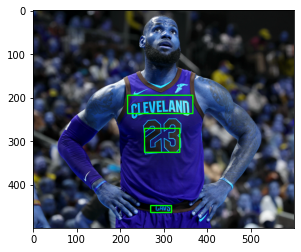

In [57]:
original = cv2.imread("opencv-text-detection/images/lebron_james.jpg")
post_process(scores, geometry, rW, rH, original)

**Known issue**: Performance of the integer quantized model is not on par with the other two models (dynamic-range and float16). This has been already communicated to the TFLite team [via this issue](https://github.com/tensorflow/tensorflow/issues/45958). 

One can utilize [this script](https://gist.github.com/sayakpaul/24314074d16018c1ce1b7699cc8395ab#file-text_detection_video-py) and perform real-time text detection. 

Results on my humble MacBook Air (13-inch, 2017) (Processor: 1.8 GHz Intel Core i5) (Memory: 8 GB 1600 MHz DDR3):

```shell
$ text_detection_video.py --east east_model_float16.tflite
[INFO] starting video stream...
[INFO] elasped time: 73.27
[INFO] approx. FPS: 1.17
```

**Other details**: 
- **TensorFlow version**: 2.3.0 
- **Model**:  [float16](https://github.com/sayakpaul/Adventures-in-TensorFlow-Lite/releases/download/v0.6.0/east_model_float16.tar.gz)

A demo of the real-time results is available [here](https://youtu.be/CpywwaAmHPs). 

To actually perform OCR, one can further process these results with a library like `pytesseract`. Refer to [this blog post](https://www.pyimagesearch.com/2018/09/17/opencv-ocr-and-text-recognition-with-tesseract/) if you want to do it right away. 

**Cleanup scripts**

In [40]:
!rm -rf opencv-text-detection
!rm -rf coco_text_100
!rm -rf coco_text_100.tar.gz
!rm -rf east_model_int8.tflite